In [1]:
import sys
from collections import OrderedDict
import matplotlib.pyplot as plt
import parselmouth
import re
import pandas as pd
import time
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb

In [2]:
def run_script_with_pluseq(audio_file_path):
    # Generate data and profile_data files using prosogram in praat    
    init_script = 'include prosomain.praat\n'
    init_script += 'call prosogram file=' + file_in + ' save=yes draw=no\n'
    init_script += 'exit'
    script = init_script
    to_include = True
    while to_include:
        match = re.search(r'^include ((?:\w|\.)+)', script, re.MULTILINE)
        if match:
            with open(match.group(1)) as f:
                script = script[:match.start()] + f.read() + '\n' + script[match.end():]
        else:
            to_include = False

    script = re.sub(r'((?:\w|\.)+\$)\s*\+=', r'\1 = \1 +', script)
    parselmouth.praat.run(script)

In [3]:
#Now using the datafiles for patterns

def process_datafiles(file_in):
    datafile_in = file_in[:-4] + "_data.txt" #removing ".wav"

    f = open(datafile_in)

    text = f.read()
    lines = text.split('\n')

    new_lines = []

    for line in lines:
        split_line = line.split('\t')
        new_lines.append(split_line)

    row_label_index = new_lines[0].index("rowLabel")
    nucl_t1_index = new_lines[0].index("nucl_t1")
    nucl_t2_index = new_lines[0].index("nucl_t2")
    f0_start_index = new_lines[0].index("f0_start")
    f0_end_index = new_lines[0].index("f0_end")
    f.close()
    return new_lines,row_label_index,f0_start_index,f0_end_index

In [4]:
def process_profile_data(file_in):
    profile_in = file_in[:-4] + "_profile_data.txt"

    fp = open(profile_in)

    text = fp.read()

    lines = text.split('\n')

    new_profile_lines = []

    for line in lines:
        split_line = line.split('\t')
        new_profile_lines.append(split_line)

    speech_rate = new_profile_lines[1][new_profile_lines[0].index("SpeechRate")]
    speech_time = new_profile_lines[1][new_profile_lines[0].index("SpeechTime")]
    f0_mean = float(new_profile_lines[1][new_profile_lines[0].index("F0MeanHz")])
    pitch_top = float(new_profile_lines[1][new_profile_lines[0].index("PitchTopHz")])
    pitch_bottom = float(new_profile_lines[1][new_profile_lines[0].index("PitchBottomHz")])

    fp.close()
    
    return f0_mean,pitch_top,pitch_bottom

In [5]:
def comparison(f0_value, pitch_top, pitch_bottom, f0_mean):
    L_value = abs(f0_value - pitch_bottom)
    M_value = abs(f0_value - f0_mean)
    H_value = abs(f0_value - pitch_top)

    if L_value <= M_value and L_value < H_value:
        return "L"
    elif M_value < L_value and M_value <= H_value:
        return "M"
    else:
        return "H"

In [6]:
#Getting L,H,M from data

def get_labelled_rows(new_lines,row_label_index,f0_start_index,f0_end_index,f0_mean,pitch_top,pitch_bottom):
    new_lines = new_lines[1:] #remove header

    labelled_rows = OrderedDict()

    for row in new_lines:
        if len(row) > 1:
            
            label = row[row_label_index]
            f0_start = float(row[f0_start_index])
            f0_end = float(row[f0_end_index])

            if f0_start == f0_end:
                result_pitch = comparison(f0_start, pitch_top, pitch_bottom, f0_mean)
                labelled_rows[label] =  result_pitch#, nucl_t1, nucl_t2]

            else:
                start_label = comparison(f0_start, pitch_top, pitch_bottom, f0_mean)
                end_label = comparison(f0_end, pitch_top, pitch_bottom, f0_mean)
                result_pitch = start_label + "-" + end_label
                labelled_rows[label] =  result_pitch#, nucl_t1, nucl_t2]
    return labelled_rows

In [7]:
def visualising_data(labelled_rows):
    #Visualising the Data
    y_array = []

    for i in labelled_rows.keys():
        if labelled_rows[i] == 'H' or labelled_rows[i] == 'H-H':
            y_array.append(float(1))
        elif labelled_rows[i] == 'M' or labelled_rows[i] == 'M-M':
            y_array.append(float(0))
        elif labelled_rows[i] == 'L' or labelled_rows[i] == 'L-L':
            y_array.append(float(-1))
        elif labelled_rows[i] == 'L-M' or labelled_rows[i] == 'M-L':
            y_array.append(float(-0.5))
        elif labelled_rows[i] == 'M-H' or labelled_rows[i] == 'H-M':
            y_array.append(float(0.5))
        elif labelled_rows[i] == 'L-H' or labelled_rows[i] == 'H-L':
            y_array.append(float(0))
        else:
            y_array.append(float(0))
    return y_array

In [8]:
# Function to find the index of the closest timestamp in list1 for a given timestamp
def find_closest_index(target, lst):
    return np.abs(np.array(lst) - target).argmin()

In [9]:
l2 = [10.4, 14.4, 18.45, 28.35, 37.9, 41.65, 48.95, 54, 61,66.4]
l3 = [13.2,20.05,28.95,36.4]
l4 = [8.95,19.05,26.3,29.7,34.4]
l5 = [9.05,14.57,19.5,26.54,32.54,37.5,44.67]
l6 = [7.85,16.75,25.13]
l7 = [10.7,20.3,25.6,30.8,36.1,42.76]
l8 = [10.5,17.5,24,34.3]
l9 = [6.5,10.8,15.4,26.7]
stop_list = [l2,l3,l4,l5,l6,l7,l8,l9]

In [10]:
l2=[]
l3=[8.56]
l4=[1.25,2.4,3.55,15.75]
l5=[30.15]
l6=[9.3,10.85,13.1]
l7=[6.5,13.7]
l8=[25.5]
l9=[]
comma_list = [l2,l3,l4,l5,l6,l7,l8,l9]

In [11]:
l2=[2.2]
l3=[1.55]
l4=[]
l5 = [1.57]
l6=[1.4]
l7=[]
l8=[]
l9=[]
ex_list = [l2,l3,l4,l5,l6,l7,l8,l9]

In [12]:
phrase_end = [stop_list,comma_list,ex_list]

In [13]:
%%capture
df_list= []
len_list = []
for num in range(2,10):
    name = "telugu_para2"
    wav_file =name+".wav"
    file_in = './wav_files/'+wav_file
    start_time = time.time()
    run_script_with_pluseq(file_in)
    
    new_lines,row_label_index,f0_start_index,f0_end_index = process_datafiles(file_in)
    f0_mean,pitch_top,pitch_bottom = process_profile_data(file_in)
    
    labelled_rows = get_labelled_rows(new_lines,row_label_index,f0_start_index,f0_end_index,f0_mean,pitch_top,pitch_bottom)
    
    y_array = visualising_data(labelled_rows)
    list_x =(list(labelled_rows.keys()))
    x = [float(j) for j in list_x]
    data = {'Time Stamps (s)': x, 'Values': y_array, 'Labels': [labelled_rows["{:.3f}".format(row)] for row in x]}
    df = pd.DataFrame(data)
    df["punc"] = 0 # "ntg"
    
    for i in range(3):
#         if(i==0):
#             punctuation = "."
#         elif(i==1):
#             punctuation = ","
#         elif (i==2):
#             punctuation = "!"
        punctuation = 1 #";" => end of phrase

        list1 = df['Time Stamps (s)'].tolist()
        list2 = phrase_end[i][num-2]
        closest_indices = [find_closest_index(timestamp, list1) for timestamp in list2]
        for i, timestamp in enumerate(list2):
            closest_index = closest_indices[i]
            closest_timestamp = list1[closest_index]
            df.at[closest_index, "punc"] = punctuation
    
    dx_next=[]
    dx_prev=[1]
    for i in range(1,len(df)):
        dx_prev.append(df["Time Stamps (s)"][i] - df["Time Stamps (s)"][i-1])
        dx_next.append(df["Time Stamps (s)"][i] - df["Time Stamps (s)"][i-1])
    dx_next.append(1)
    
    df["dx_next"] = dx_next
    df["dx_prev"] = dx_prev

    df_list.append(df)
    len_list.append(len(df))
    print(f"{file_in} file processed in {time.time()-start_time:.3f} sec")

In [14]:
df = pd.concat(df_list, ignore_index=True)
dy_next=[]
dy_prev=[0]
for i in range(1,len(df)):
    dy_prev.append(df['Values'][i] - df['Values'][i-1])
    dy_next.append(df['Values'][i] - df['Values'][i-1])
dy_next.append(0)

df["dy_next"] = dy_next
df["dy_prev"] = dy_prev
dataset = df.copy()

In [15]:
np.unique(dataset["punc"])

array([0, 1])

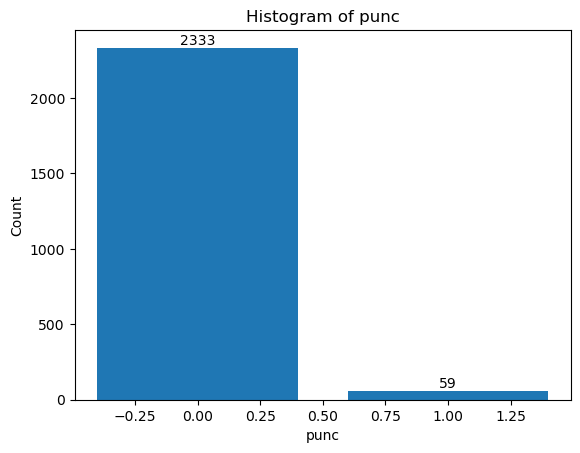

In [16]:
import matplotlib.pyplot as plt

column_name = "punc"
value_counts = dataset[column_name].value_counts()

plt.bar(value_counts.index, value_counts)
plt.xlabel(column_name)
plt.ylabel("Count")
plt.title(f"Histogram of {column_name}")

for i, value in enumerate(value_counts):
    plt.text(i, value, str(value), ha='center', va='bottom')

plt.show()

In [17]:
dataset

,Time Stamps (s),Values,Labels,punc,dx_next,dx_prev,dy_next,dy_prev
0,0.535,0.0,M,0,0.160,1.000,0.0,0.0
1,0.695,0.0,M,0,0.200,0.160,-1.0,0.0
2,0.895,-1.0,L,0,0.130,0.200,0.0,-1.0
3,1.025,-1.0,L,0,0.230,0.130,0.0,0.0
4,1.255,-1.0,L,0,0.120,0.230,1.5,0.0
...,...,...,...,...,...,...,...,...
2387,65.225,-1.0,L,0,0.160,0.175,0.5,-1.0
2388,65.385,-0.5,M-L,0,0.235,0.160,0.0,0.5
2389,65.620,-0.5,M-L,0,0.140,0.235,-0.5,0.0
2390,65.760,-1.0,L,0,0.120,0.140,0.0,-0.5


In [18]:
new_column_names = {'punc': 'label'}
df = df.rename(columns=new_column_names)
columns_to_drop = ['Time Stamps (s)', 'Labels']
data = df.drop(columns=columns_to_drop)
np.random.seed(42)

In [19]:
X = data.drop('label', axis=1)
y = data['label']

In [20]:
X_train, X_test, y_train, y_test = X[:(-1)*len_list[-1]], X[(-1)*len_list[-1]:],  y[:(-1)*len_list[-1]],  y[(-1)*len_list[-1]:]
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(2093, 5) (2093,) (299, 5) (299,)
